In [30]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
class Manifold:
    """A wrapper class for a collection of geodesic level sets which
    constitute an invariant manifold.
    
    Methods defined here:
    
    Manifold.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                min_sep, max_sep)
    Manifold.add_level_sets(num_sets_to_add)
    Manifold.check_ab()
    Manifold.compute_lambda3_and_weights()
        
    """
  
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep
                ):
        """Manifold.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                min_sep, max_sep)
        
        Initializes a Manifold object without adding any level sets.
                
        param: init_pos --     NumPy array containing the initial position (x,y,z)
                               from which the manifold is constructed
        param: dom_bound --    Domain boundaries, as a six-element list.
                               Format: [xmin, xmax, ymin, ymax, zmin, zmax]
        param: max_geo_dist -- Maximum geodesic distance. Used to terminate
                               development of manifold
        param: min_s_step --   Minimum step along the s abscissa (for local
                               evaluation of b-spline interpolations of 
                               any given level set)
        param: max_s_step --   Minimum step along the s abscissa (for local
                               evaluation of b-spline interpolations of 
                               any given level set)
        param: dist --         The (initial) radial distance from each
                               point in a given level set, to the 
                               'radially connected' point in the
                               construction of the next level set
        param: dist_tol --     Numerical tolerance parameter for the
                               above. 0 <= dist_tol <= 1
        param: plane_tol --    Numerical tolerance parameter for the acceptance of
                               points as members of a plane
        param: tan_tol --      Tolerance for angular offset between consecutive
                               tangential (half-plane defining) vectors
                               (used in normalized dot product)
        param: min_ang --      Minimal radial angular deviation between
                               consecutive constructed level sets,
                               under which 'dist' is increased
                               before the _next_ level set is 
                               constructed
        param: max_ang --      Maximal radial angular deviation between
                               consecutive constructed level sets,
                               over which 'dist' is decreased,
                               the most recent attempt at creating
                               a level set is discarded, and
                               attempted anew with decreased 'dist'
        param: min_dist_ang -- Minimal product of 'dist' and
                               radial angular deviation between
                               consecutive constructed level sets,
                               under which 'dist' is increased
                               before the _next_ level set is
                               constructed
        param: max_dist_ang -- Maximal product of 'dist' and
                               radial angular deviation between
                               consecutive constructed level sets,
                               over which 'dist' is decreased,
                               the most recent attempt at creating
                               a level set is discarded, and
                               attempted anew with decreased 'dist'
        param: min_sep --      Minimal distance allowed between
                               (neighboring) points in a level set.
        param: max_sep --      Maximal distance allowed between
                               (neighboring) points in a level set        
        """
        self.levelsets    = []
        self.noise_gauge  = []
        self.dist         = dist
        self.num_sets     = 0
        self.geo_dist     = 0
        self.input_params = InputManifoldParameters(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, 
                                                     dist_tol, plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, 
                                                    max_dist_ang, min_sep, max_sep
                                                   )
        
    def add_level_sets(self, num_sets_to_add):
        """Manifold.add_level_sets(num_sets_to_add)
        
        Adds a specified number of geodesic level sets to the Manifold.
        
        Writes the number of points in each successfully added level set,
        as well as the elapsed time, to console.
        
        If no more geodesic level sets can be added, exceptions with
        descriptive names and docstrings are raised.
        
        param: num_sets_to_add -- The (integer) number of geodesic level sets to add.
        
        """
        n = 0
        try:
            if self.num_sets == 0 and num_sets_to_add > 0:
                self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params))
                self.num_sets += 1
                n += 1
        except OutsideOfDomainError as e:
            print(e.value)
            print('Point near edge. Could not complete first level set. Returning empty manifold')
            return
        while (n < num_sets_to_add and self.geo_dist <= self.input_params.max_geo_dist):
            t_start = time.time()
            try:
                self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params,
                                                      self.levelsets[self.num_sets-1])
                                     )
            except (OutsideOfDomainError, NeedSmallerDistError) as e:
                if type(e) is OutsideOfDomainError:
                    try:
                        if (self.dist > self.input_params.min_sep):
                            self.dist = self.input_params.min_sep
                            try:
                                self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist,
                                                               self.input_params, self.levelsets[self.num_sets-1]))
                                ### Experimental ###
                                #self.levelsets[-1].next_dist = failed_dist
                            except NeedSmallerDistError as e:
                                print('Could not complete geodesic level set number {}'.format(n))
                                raise CannotDecreaseDistFurtherError('Cannot add more level sets without violating min_sep')
                                #raise RuntimeError('Failed to locate needed point at minimum step length.')
                        else:
                            raise CannotDecreaseDistFurtherError('Cannot add more level sets without violating min_sep')
                            #raise RuntimeError('Failed to locate needed point at minimum step length.')
                    except (OutsideOfDomainError, CannotDecreaseDistFurtherError) as e:
                        print(e.value)
                        break
                else:
                    print(e.value)
                    break
            #except CannotDecreaseDistFurtherError as e:
            #    print(e.value)
            #    break
        
            self.num_sets += 1
            self.geo_dist += self.dist
            self.dist = self.levelsets[-1].next_dist
            self.noise_gauge.append(self.geo_dist*2*np.pi/len(self.levelsets[-1].points))
            n += 1
            print('Level set {:4d} completed. Number of points: {:4d}. Cumulative geodesic distance: {:.3f}.'\
                  ' Elapsed time: {:.2f} seconds.'.format(len(self.levelsets), 
                                                        len(self.levelsets[-1].points), 
                                                        self.geo_dist, 
                                                        time.time() - t_start
                                                       )
                 )

            if (n > 10):
                if (np.mean(self.noise_gauge[-5:]) < 0.5*np.mean(self.noise_gauge[:-5])):
                    print('Numerical noise detected. Stopping.')
                    break
                    
        if (self.geo_dist > self.input_params.max_geo_dist):
            print('Max geodesic distance reached. No more level sets can be added in the current environment.')
    
    def check_ab(self):
        """Manifold.check_ab()
        
        Checks which of the points in the parametrization of the manifold
        satisfy the A- and B- criteria for (strong) LCSs.
        
        The boolean flag 'in_ab' for each of the Point instances in all
        the GeodesicLevelSet instances is set when this function is
        called.
        """
        for level in self.levelsets:
            for point in level.points:
                if (point.in_ab is None):
                    point._is_in_ab()
        print('Points in AB domain identified.')
        
    def compute_lambda3_and_weights(self):
        """Manifold.compute_lambda3_and_weights()
        
        Assigns a B-spline interpolated lambda3 value to each point in the manifold,
        in addition to a numerical weighting factor intended to approximate the
        part of the surface area of the manifold which is associated to each
        individual point.
        """
        for i, lset in enumerate(self.levelsets):#range(len(self.levelsets)):
        #for i in range(len(self.levelsets)):
            n = len(lset.points)
            #n = len(self.levelsets[i].points)
            for j, point in enumerate(lset.points):
            #for j in range(n):
                point.lambda3 = lm3_itp(point.pos)
                point.weight = 0.5*(lset.dist + self.levelsets[min(i+1,len(self.levelsets)-1)].dist)*\
                               0.5*(cy_norm2(point.pos - lset.points[np.divmod(j-1,n)[1]].pos)+
                                    cy_norm2(point.pos - lset.points[np.divmod(j+1,n)[1]].pos)
                                   )
                #self.levelsets[i].points[j].lambda3 = lm3_itp(self.levelsets[i].points[j].pos)
                #self.levelsets[i].points[j].weight = (self.levelsets[i].dist +
                #    self.levelsets[min(i+1,len(self.levelsets)-1)].dist)/2 * (np.linalg.norm(self.levelsets[i].points[j].pos -
                #    self.levelsets[i].points[np.divmod(j-1,n)[1]].pos) + np.linalg.norm(self.levelsets[i].points[j].pos -
                #    self.levelsets[i].points[np.divmod(j+1,n)[1]].pos))/2
        print('Point weights identified.')

In [3]:
class InputManifoldParameters:
    """A wrapper class for a set of parameters which define an invariant manifold
    parametrized in terms of geodesic level sets.
    
    Methods defined here:
    
    InputManifoldParameters.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                                     plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                                     min_sep, max_sep
                                    )
        
    """

    # Constructor
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep):
        """InputManifoldParameters.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                                 plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                                 min_sep, max_sep
                                )
        
        For most practical purposes, a dictionary disguised as a class, intended for use in the interaction
        between a Manifold instance and its constituent GeodesicLevelSet instances, in order to shorten
        the involved call signatures.
        """

        self.init_pos = init_pos
        self.max_geo_dist = max_geo_dist
        self.dom_bound = dom_bound
        self.min_s_step = min_s_step
        self.max_s_step = max_s_step
        self.dist_tol = dist_tol
        self.plane_tol = plane_tol
        self.tan_tol = tan_tol
        self.min_ang = min_ang
        self.max_ang = max_ang
        self.min_dist_ang = min_dist_ang
        self.max_dist_ang = max_dist_ang
        self.min_sep = min_sep
        self.max_sep = max_sep

In [4]:
class GeodesicLevelSet:
    """A wrapper class for a collection of points which
    parametrize a geodesic level set.
    
    Methods defined here:
    
    GeodesicLevelSet.__init__(level_num, dist, input_params, prev_set)
    GeodesicLevelSet._generate_first_set(input_params)
    GeodesicLevelSet._generate_set(dist, input_params, prev_set)
    GeodesicLevelSet._revise_set(set_suggestion, prev_set, input_params)
    GeodesicLevelSet._stabs_in_the_dark(index, prev_set, input_params, inbetween)
    GeodesicLevelSet._remove_loops(set_suggestion, min_sep, max_sep)
    """
    
    
    # Constructor
    def __init__(self, level_num, dist, input_params, prev_set=None):
        """GeodesicLevelSet.__init__(level_num, dist, input_params, prev_set)
        
        Constructor for a GeodesicLevelSet instance.
        
        param: level_num --    The (integer) number of geodesic level sets which have
                               been computed prior to this one. Only used to differentiate
                               between the base-case construction routine for the very
                               first level set, which is made to be a small, planar
                               circle, and all others, which are constructed by means
                               of trajectories orthogonal to a vector field.
        param: dist --         If level_num == 0: Ten times the radius of the initial
                               level set, approximated as a planar circle.
                               Else: The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: prev_set --     The GeodesicLevelSet instance representing the immediately
                               preceding geodesic level set in the manifold in question.
                               If None and level_num > 0: Raises an exception
        
        """
        
        self.dist = dist
        
        # Set in sub-functions: self.next_dist
        
        if (level_num == 0):
            new_set = self._generate_first_set(input_params)
        else:       
            set_suggestion = self._generate_set(dist, input_params, prev_set)
            new_set = self._revise_set(set_suggestion, prev_set, input_params)
            
            
        self.points = new_set
        self.next_dist = self.dist
            
        # Lag spline-interpolasjon av punktene i levelsettet, hvor duplikat av første
        # punkt legges sist for å generere pseudo-periodisk interpolasjonsobjekt
        # (styres m/ wraparound = True), og vi 'padder' med et (likt) antall punkter
        # i begge retninger sett fra s = 0, for å skape en glattere skjøt.

        self.interpolation = NDCurveBSplineInterpolator(np.asarray([point.pos for point in self.points]),wraparound=True,pad_points=2)
            
    def _generate_first_set(self, input_params):
        """GeodesicLevelSet._generate_first_set(input_params)
        
        Generates the initial geodesic level set in the parametrization of a
        manifold.
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general***
            
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.

        """
        first_set = []
        # Parameters only used in this function
        init_radius_min_sep_factor = 1/10
        init_radius = input_params.min_sep*init_radius_min_sep_factor
        init_set_extra_points = 0
        #if (np.ceil(2*np.pi*init_radius/input_params.min_sep).astype(int) < 6):
        #    init_set_extra_points = 4
        n_points = 8
        # Compute an integer number of points that satisfies both min_dist and max_dist
        #n_points = np.ceil(2*np.pi*init_radius/input_params.min_sep).astype(int) + init_set_extra_points
        print('Number of points in first geodesic level: {}'.format(n_points))
        #ix1 = Evec1() # <= For spherical shell
        #ix1 = LinearSpecialInterpolator(xi1,x,y,z) # <= For ABC flow
        #ix2 = Evec2() # <= For spherical shell
        #ix2 = LinearSpecialInterpolator(xi2,x,y,z) # <= For ABC flow
        if not sinusoidalsurface:
            for i in range(n_points):
                newcoord = input_params.init_pos + init_radius*(xi1_itp(input_params.init_pos)
                            *np.cos(2*np.pi*i/n_points) + xi2_itp(input_params.init_pos)*np.sin(2*np.pi*i/n_points))
                if (not in_domain(newcoord, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                first_set.append(Point(pos=newcoord, prev_vec=cy_normalize(newcoord - input_params.init_pos),
                                    tan_vec=cy_normalize(cy_cross_product(cy_normalize(cy_cross_product(xi1_itp(input_params.init_pos),
                                    xi2_itp(input_params.init_pos))), cy_normalize(newcoord - input_params.init_pos)))))
        else:
            for i in range(n_points):
                newcoord = np.array([np.pi,np.pi,np.pi]) + init_radius*(np.array([1.,0,0])*np.cos(2*np.pi*i/n_points) + 
                                                     np.array([0,1.,0])*np.sin(2*np.pi*i/n_points))
                first_set.append(Point(pos=newcoord, prev_vec = cy_normalize(newcoord-np.array([np.pi,np.pi,np.pi])),
                                      tan_vec = cy_normalize(cy_cross_product(cy_normalize(newcoord),np.array([0,0,1.])))))
        self.next_dist = self.dist
        
        return first_set
        
    def _generate_set(self, dist, input_params, prev_set):
        """GeodesicLevelSet._generate_set_set(dist, input_params, prev_set)
        
        Generates a geodesic level set, for level_num > 0, in the parametrization
        of a manifold.
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general***
        
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: prev_set --     The GeodesicLevelSet instance representing the immediately
                               preceding geodesic level set in the manifold in question.
                               If None: Raises an exception                             

        """
        set_suggestion = []
        if not prev_set:
            raise RuntimeError('Missing previous geodesic level set!')
        for i in range(len(prev_set.points)):
            try:
                set_suggestion.append(Point._find_ordinary_point(i, prev_set, input_params, dist, inbetween=False))
                if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
            except PointNotFoundError as e:
                best_point, valid_point = self._stabs_in_the_dark(i, prev_set, input_params, inbetween=False)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.append(best_point)
                else:
                    raise NeedSmallerDistError('Resetting with smaller dist')
        return set_suggestion

    # Check that all restrictions are satisfied + setting next_dist
    def _revise_set(self, set_suggestion, prev_set, input_params):
        """GeodesicLevelSet._revise_set(set_suggestion, prev_set, input_params)
        
        A function which enforces a suggested geodesic level set to conform 
        with preset tolerance levels (cf. input_params).
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general ***
            
        param: set_suggestion -- A suggestion for the _next_ geodesic level set,
                                 as computed by _generate_set
        param: prev_set       -- The immediately preceding geodesic level set
        param: input_params   -- An InputGeodesicParameters instance, containing 
                                 a set of parameters which define the parametrization
                                 of the manifold, of which this GeodesicLevelSet is a
                                 constituent part. See the InputGeodesicParameters
                                 docstring for details.
                                 
        return: set_suggestion -- (Usually) altered version of the input set_suggestion,
                                  where no points in the parametrization are too far 
                                  apart or too close together, all points pass
                                  local curvature tests and detected loops resulting
                                  from numerical noise have been eliminated.
        """
        
        # Curvature tests
        over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                     input_params.max_ang)
        over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points,
                                            self.dist, input_params.min_dist_ang, input_params.max_dist_ang)

        # If curvature is too large
        dist_reduced = False
        while ((over_max_ang or over_max_dist_ang) and self.dist >= 2*input_params.min_sep):
            self.dist = 0.5*self.dist
            set_suggestion = []
            for i in range(len(prev_set.points)):
                try:
                    set_suggestion.append(Point._find_ordinary_point(i, prev_set, input_params, self.dist, 
                                                                 inbetween=False))
                    if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                        raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                except PointNotFoundError as e:
                    try:
                        best_point, valid = self._stabs_in_the_dark(i, prev_set, input_params, inbetween=False)
                        if (not in_domain(best_point.pos, input_params.dom_bound)):
                            raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                        if valid:
                            set_suggestion.append(best_point)
                        else:
                            raise NeedSmallerDistError('Point not found upon throwing shit at wall in revise_set')
                    except NeedSmallerDistError as e:
                        raise e
            over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                    input_params.max_ang)
            over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points, 
                                                self.dist, input_params.min_dist_ang, input_params.max_dist_ang)
            dist_reduced = True
            self.next_dist = self.dist
        if ((over_max_ang or over_max_dist_ang)):
            print('Smaller step than min_sep required with current requirements. Continuing anyway')
        # If curvature is very small
        if (under_min_ang and under_min_dist_ang and not dist_reduced):
            self.next_dist = min(self.dist*2, input_params.max_sep)
        else:
            self.next_dist = self.dist
        # Check whether neighboring points are close enough to each other
        add_point_after = max_dist_test(set_suggestion, input_params.max_sep)
        
        j = 0
        
        # Adjusting prev_vec
        prev_vec_tol = 0.1
        for i in range(len(set_suggestion)):
            itp_prev_vec = cy_normalize((set_suggestion[np.divmod(i-1,len(set_suggestion))[1]].prev_vec
                            + set_suggestion[np.divmod(i-1,len(set_suggestion))[1]].prev_vec)/2)
            if (np.dot(set_suggestion[i].prev_vec, prev_set.points[i].prev_vec) < 1-prev_vec_tol):
                if (np.dot(itp_prev_vec, prev_set.points[i].prev_vec) > 1-prev_vec_tol):
                    set_suggestion[i].prev_vec = itp_prev_vec
        
        # Insert points wherever points are too far from each other
        for i in add_point_after:
            try:
                set_suggestion.insert(i+j+1, Point._find_ordinary_point(i, prev_set, input_params, self.dist,
                                                                    inbetween=True))
                if (not in_domain(set_suggestion[i+j+1].pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
            except PointNotFoundError as e:
                best_point, valid_point = self._stabs_in_the_dark(i, prev_set, input_params, inbetween=True)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.insert(i+j+1, best_point)
                else:
                    raise NeedSmallerDistError('Resetting with smaller dist')
            j += 1
        
        # Removing loops
        set_suggestion = GeodesicLevelSet._remove_loops(set_suggestion, input_params.min_sep, input_params.max_sep)
        
        # Check whether neighboring points are far enough from each other
        to_be_deleted = min_dist_test(set_suggestion, input_params.min_sep, input_params.max_sep)

        # Delete points wherever points are too close to each other
        num_removed = 0
        for i in to_be_deleted:
            set_suggestion.pop(i-num_removed)
            num_removed += 1
        return set_suggestion
        
    
    # Finding difficult points by varying parameters
    def _stabs_in_the_dark(self, index, prev_set, input_params, inbetween):
        """GeodesicLevelSet._stabs_in_the_dark(index, prev_set, input_params, inbetween)
        
        Attempts to find a point in the parametrization of a geodesic level set when
        the conventional approach fails. Uses different estimates of the tangential 
        vector defining the half-plane in which a new point is allowed to live, 
        as well as different angular offsets wrt the previous level set.
        
        If all else fails, the tolerance parameters are relaxed, in a last-ditch attempt
        to find a passable point.
        
        *** This function is called by the constructor _when_needed_, explicitly calling
            this function should never be necessary and is not advised in general ***
        
        param: index -- Index of the point in the previous geodesic level set, from which 
                        one attempts to develop a point in the new set
        param: prev_set -- The most recently computed (and accepted) GeodesicLevelSet instance
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: inbetween -- Boolean flag indicating whether or not the new point should
                            be constructed from a ficticious (as in, interpolated) 
                            point inbetween neighboring points in the previous level set
                            
        return: best_point -- The best attempt at finding the coordinates of the new point
        return: valid_point -- Boolean flag, indicating whether or not the new point 
                               lies within the plane in which we're searching, and whether or 
                               not the (Euclidean) distance separating the new point from
                               its 'origin' in the previous level set is as requested
                               (to the given tolerance, cf. input_params)
        """

        s_offsets = np.array([0.25,0.2,0.15,0.1,0.05,0.01])
        #ang_offsets = np.array([-2,2,-4,4,-6,6,-8,8,-10,10,-12,12,-14,14,-16,16,-18,18,-20,20,-22,22,-24,24,
        #                        -26,26,-28,28,-30,30,-32,32,-34,34,-36,36,-38,38,-40,40])*np.pi/180
        ang_offsets = np.array([-1,1,-2,2,-3,3,-4,4,-5,5,-6,6,-7,7,-8,8,-9,9,-10,10])*np.pi/180
        #ang_offsets = np.array([-0.5,0.5,-1,1,-1.5,1.5,-2,2,-2.5,2.5,-3,3,-3.5,3.5,-4,4,-4.5,4.5,-5,5])*np.pi/180
        #ang_offsets = np.array([-0.5,0.5,-1,1,-1.5,1.5,-2,2,-2.5,2.5,-3,3,-3.5,3.5,-4,4,-4.5,4.5,-5,5,
        #                       -5.5,5.5,-6,6,-6.5,6.5,-7,7,-7.5,7.5,-8,8,-8.5,8.5,-9,9,-9.5,9.5,-10,10])*np.pi/180
        
        best_trial_dist = 0
        best_point = prev_set.points[index]
        
        plane_tol = input_params.plane_tol
        
        for s_offset in s_offsets:
            for ang_offset in ang_offsets:
                pos_curr, trial_dist, valid_point = Point._find_difficult_point(index, prev_set, input_params,
                                                        self.dist, inbetween, plane_tol, s_offset, ang_offset)
                if (valid_point):
                    #print('Angular offset = ', ang_offset*180/np.pi)
                    return pos_curr, True
                elif (abs(trial_dist - self.dist) < abs(best_trial_dist - self.dist)):
                    best_trial_dist = trial_dist
                    best_point = pos_curr
            
        ## Try again with higher tolerance...
        # Parameters
        plane_tol_factor = 10
        dist_tol_factor  = 10

        plane_tol = plane_tol_factor*input_params.plane_tol

        for s_offset in s_offsets:
            for ang_offset in ang_offsets:
                pos_curr, trial_dist, valid_point = Point._find_difficult_point(index, prev_set, input_params,
                                                        self.dist, inbetween, plane_tol, s_offset, ang_offset)
                if (valid_point):
                    print('Returned ass point after throwing shit at wall')
                    return pos_curr, True
                elif (abs(trial_dist - self.dist) < abs(best_trial_dist - self.dist)):
                    best_trial_dist = trial_dist
                    best_point = pos_curr
        if (abs(best_trial_dist - self.dist) < self.dist*input_params.dist_tol*dist_tol_factor):
            print('Returned VERY ass point after throwing shit at wall')
            return best_point, True
        else:
            print('None of the shit stuck to the wall')
            return best_point, False
    
    @staticmethod
    def _remove_loops(set_suggestion, min_sep, max_sep):
        """GeodesicLevelSet._remove_loops(set_suggestion, min_sep, max_sep)
        
        A function which detects and removes nonphysical loops in a suggested 
        geodesic level set, facilitating extended growth of a manifold.
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general ***
            
        param: set_suggestion -- A suggestion for the _next_ geodesic level set,
                                 as computed by _generate_set
        param: min_sep --        The minimum allowed distance separating points
                                 in a geodesic level set
        param: max_sep --        The maximum allowed distance separating points
                                 in a geodesic level set
                                 
        return: new_set_suggestion -- A new set suggestion, based upon the input set_suggestion,
                                      where the aforementioned loops have been removed
        """
   
        did_something = False

        n = len(set_suggestion)

        if (n > 20):
            to_be_added = np.ones(n,dtype=np.bool)
            seps = np.empty(n)
            for i in range(n):
                seps[i] = np.linalg.norm(set_suggestion[np.divmod(i+1,n)[1]].pos - set_suggestion[i].pos)

            for i in range(n):
                # Forward
                for j in range(2,int(n/4)):
                    arcdist = sum(seps[i:min(n,i+j)]) + sum(seps[0:max(i+j-n,0)])
                    if ((np.linalg.norm(set_suggestion[np.divmod(i+j,n)[1]].pos - set_suggestion[i].pos)
                        < min(max_sep, 0.7*arcdist))
                        and (len(np.nonzero(to_be_added[i:min(i+j+1,n)])[0]) == len(to_be_added[i:min(i+j+1,n)]))
                        and (len(np.nonzero(to_be_added[0:max(i+j-n+1,0)])[0]) ==
                             len(to_be_added[0:max(i+j-n+1,0)]))):

                        did_something = True

                        to_be_added[i+1:min(i+j,n)] = False
                        to_be_added[0:max(i+j-n,0)] = False
                # Backward
                for j in range(2,int(n/4)):
                    arcdist = sum(seps[max(0,i-j):i]) + sum(seps[min(i-j+n,n):n])
                    if ((np.linalg.norm(set_suggestion[np.divmod(i-j,n)[1]].pos - set_suggestion[i].pos)
                        < min(max_sep, 0.7*arcdist))
                        and (len(np.nonzero(to_be_added[min(i-j+n,n):n])[0]) ==
                                 len(to_be_added[min(i-j+n,n):n]))
                        and (len(np.nonzero(to_be_added[max(0,i-j):i+1])[0]) ==
                             len(to_be_added[max(0,i-j):i+1]))):

                        did_something = True

                        to_be_added[min(i-j+n+1,n):n] = False
                        to_be_added[max(0,i-j+1):i] = False
                new_set_suggestion = []
                for i in range(n):
                    if (to_be_added[i]):
                        new_set_suggestion.append(set_suggestion[i])

        else:
            new_set_suggestion = set_suggestion

        if (did_something):
            print('remove_loops did something!')

        return new_set_suggestion

In [5]:
class Point:
    """A class of which a collection of instances parametrizes a 
    geodesic level set.
    
    Methods defined here:
    
    Point.__init__(level_num, dist, input_params, prev_set)
    Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
    Point._find_difficult_point(index, prev_set, input_params, dist, inbetween, 
                                plane_tol, s_offset, ang_offset)
    Point._check_ab()
    Point._prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol, 
                             prev_point, input_params, s_offset, ang_offset)
    Point._iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit,
                            backtracked, s_lower, s_upper, pos_curr, tan_vec, 
                            dist, plane_tol, prev_point, input_params, s_offset, 
                            ang_offset)
    Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol, 
                      prev_point, input_params, s_offset, ang_offset)
    Point._next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, 
                  input_params)
    Point._compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset)
    Point._weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper)
    Point._weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper)

    """
    def __init__(self, pos, prev_vec = None, tan_vec = None):
        """Point.__init__(pos, prev_vec, tan_vec)
        
        Constructor for a Point object.
        
        *** This function is called by various other methods
            (classmethods or otherwise) of the Point class ***
        
        param: pos --      (NumPy) array specifying the (Cartesian) point coordinates
        param: prev_vec -- Normalized vector, as a (NumPy) array, specifying the direction 
                           of the straight line from the previous point to this one. 
        param: tan_vec --  Normalized vector, as a (NumPy) array, specifying the local
                           tangential vector, used in order to define a half-plane
                           'radially' outwards from _this_ point.
                           
        """
        # Remember my position
        self.pos = pos
        # Remember my "previous" vector
        self.prev_vec = prev_vec
        # Remember my "tangential" vector
        self.tan_vec = tan_vec
        
        # The following member variables are not set upon construction,
        # as they are not needed prior to the LCS candidate selection 
        # process. Nevertheless, 'allocating' them decreases the 
        # indexing speed later, alas:
        # Remember if I satisfy conditions A, B, and D
        self.in_ab = None
        # Remember my lambda3 value
        self.lambda3 = None
        # Remember my "weight" (~ surrounding area)
        self.weight = None
    
    @classmethod
    def _find_ordinary_point(cls, index, prev_set, input_params, dist, inbetween):
        """Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
        
        Attempts to find a point in a new level set by conventional means.
        
        If this does not succeed, internal exception-handling occurs.
        
        If a new point cannot be found by conventional nor unconventional means, 
        descriptive RuntimeErrors are raised. 
        
        *** This function is called by methods further upwards in the hierarchy,
            namely at GeodesicLevelSet level. Explicitly calling this function
            should never be necessary and is not advised in general ***
        
        param: index --        Index of point in previous geodesic level set, from which
                               one attempts to find a point in a new set.
        param: prev_set --     The most recently computed (and accepted) GeodesicLevelSet 
                               instance
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.     
        param: inbetween --    Boolean flag indicating whether or not the new point should
                               be constructed from a ficticious (as in, interpolated) 
                               point inbetween neighboring points in the previous level set                               
                               
        return: newp -- The computed point in the new level set. 
        
        """
        
        plane_tol   = input_params.plane_tol  
        s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]

        if (inbetween):
            s_lower     = prev_set.interpolation.s[index]
            s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower),abs(s_upper - s_lower + 1))/2,1)[1]
            prev_point  = cls(prev_set.interpolation(s_prev), 
                              cls._weighted_prev_vec(index,prev_set, s_lower, s_prev, s_upper),
                              cls._weighted_tan_vec(index,prev_set,s_lower,s_prev,s_upper)
                             )            
        
        else:
            s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
            s_prev      = prev_set.interpolation.s[index]
            prev_point  = prev_set.points[index]

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle
        # and computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point._prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params)
        
        
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic 
        # circle and computing trajectories in the manifold pointed towards our best guess for the new point
        pos_curr, tan_vec, valid_point = Point._iterative_search(s_prev, prev_set.interpolation, s, ds, trial_dist,
                                                               overshoot, hit, backtracked, s_lower, s_upper,
                                                               pos_curr, tan_vec, dist, plane_tol, prev_point,
                                                               input_params
                                                              )
        
        if (valid_point):
            newp = cls(pos_curr, cy_normalize(pos_curr-prev_point.pos), tan_vec)
        else:
            raise PointNotFoundError('Point not found, throwing shit at the wall')
        return newp
    
    @classmethod
    def _find_difficult_point(cls, index, prev_set, input_params, dist, inbetween, plane_tol, s_offset, ang_offset):
        """Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
        
        Attempts to find a point in a new level set by unconventional means.
        
        If this does not succeed, internal exception-handling occurs.
        
        If a new point cannot be found descriptive RuntimeErrors are raised. 
        
        This function is never called _before_ _find_ordinary_point.
        
        *** This function is called by methods further upwards in the hierarchy,
            namely at GeodesicLevelSet level. Explicitly calling this function
            should never be necessary and is not advised in general ***
        
        param: index --        Index of point in previous geodesic level set, from which
                               one attempts to find a point in a new set.
        param: prev_set --     The most recently computed (and accepted) GeodesicLevelSet 
                               instance
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.     
        param: inbetween --    Boolean flag indicating whether or not the new point should
                               be constructed from a ficticious (as in, interpolated) 
                               point inbetween neighboring points in the previous level set
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set
                               
        return: newp -- The computed point in the new level set. 
        return: best_trial_dist -- The (Euclidean) distance separating newp and the corresponding
                                   point in the previous level set
        return: valid_point --     Boolean flag as to whether or not newp lies within the half-plane
                                   extending radially outwards from the corresponding point in the
                                   previous level set, with a satisfactory separation (Euclidean norm)
                                   between it and the corresponding point.
        
        """
        if (inbetween): 
                s_lower     = prev_set.interpolation.s[index]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower), abs(s_upper - s_lower + 1))/2, 1)[1]
        
        else:
                s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = prev_set.interpolation.s[index]
            
        prev_point  = cls(prev_set.interpolation(s_prev), 
                          cls._weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper), 
                          cls._weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper))

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle and
        # computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point._prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params,
                                                                                                    s_offset,
                                                                                                    ang_offset
                                                                                                   )
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic circle and 
        # computing trajectories in the manifold pointed towards our best guess for the new point 
        best_pos_curr, best_tan_vec, best_trial_dist, valid_point = Point._iterative_search(s_prev,
                                                                                           prev_set.interpolation,
                                                                                           s,
                                                                                           ds,
                                                                                           trial_dist,
                                                                                           overshoot, 
                                                                                           hit,
                                                                                           backtracked,
                                                                                           s_lower,
                                                                                           s_upper,
                                                                                           pos_curr,
                                                                                           tan_vec,
                                                                                           dist,
                                                                                           plane_tol,
                                                                                           prev_point,
                                                                                           input_params,
                                                                                           s_offset,
                                                                                           ang_offset)

        return cls(best_pos_curr, cy_normalize(pos_curr-prev_point.pos), best_tan_vec), best_trial_dist, valid_point
    
    def _is_in_ab(self):
        """Point._is_in_ab()
        
        Checks whether or not the point satisfies the A and B criteria
        for strong LCSs.
        
        The boolean flag 'in_ab' is set to True or False, accordingly.
        
        """
        A = lm3_itp(self.pos) > lm2_itp(self.pos) and lm3_itp(self.pos) > 1
        B = np.linalg.multi_dot((xi3_itp(self.pos),lm3_itp.hess(self.pos),xi3_itp(self.pos))) <= 0
        #B = xi3_itp(self.pos).dot(lm3_itp.hess(self.pos).dot(xi3_itp(self.pos))) <= 0
                
        self.in_ab = A and B

    

#############################################################################################################                    
############################################# Work functions ################################################
#############################################################################################################

    @staticmethod
    def _prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol, prev_point, input_params, 
                          s_offset=-1, ang_offset=0):
        """Point._prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol,
                                    prev_point, input_params, s_offset, ang_offset)
                                    
        A function which initializes a set of search parameters and boolean variables
        for later use in _iterative_search.
        
        *** This function is called by other classmethods in the Point hierarchy. 
            Explicitly calling this function elsewhere should never be
            necessary and is generally not advised. ***
            
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s_lower --      The lower permitted limit for the s parameter
        param: s_upper --      The upper permitted limit for the s parameter
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.     
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. Defaults to -1, which corresponds
                               to a conventional approach. 
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. Defaults to 0.
                               
        return: s --           New pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin
        return: ds --          Step length along the s abscissa when multiple attempts are
                               required
        return: trial_dist --  (Euclidean) distance separating prev_point and a first
                               approximation of the new point. Defaults to -1 if the
                               first approximation fails.
        return: pos_curr --    (NumPy) array of Cartesian coordinates of the first approximation
                               of the new point
        return: tan_vec --     Normalized vector (as a NumPy array) which is approximately
                               tangent to prev_point (when the previous geodesic level set
                               is viewed as a whole)
        return: overshoot --   Boolean parameter indicating whether or not the most recent
                               approximation overshot wrt the distance from the previous point.
                               As this function merely performs preparations, overshoot == False
        return: hit --         Boolean parameter indicating whether or not the most recent
                               approximation hit the target plane. As this function
                               merely performs preparations, hit == True
        return: backtracked -- Boolean parameter indicating whether or not the most recent
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter. Relevant whenever overshoot = True.
                               As this function merely performs preparations, 
                               backtracked == False
                               
        """
   
        # Find new (previous) level circle parameter (s) from which to search for new point
        s = s_start + input_params.min_s_step
        ds = input_params.min_s_step
        overshoot = False
        hit = True
        backtracked = False

        # Search for point in half-plane defined by previous point and circle tangent
        pos_curr, tan_vec, success = Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                      prev_point, input_params, s_offset, ang_offset)

        if (success):
            trial_dist = cy_norm2(pos_curr-prev_point.pos)
            #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
        else:
            trial_dist = -1
        return s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked
    
    # Iteratively search for acceptable new point
    def _iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit, backtracked, s_lower, s_upper, 
                         pos_curr, tan_vec, dist, plane_tol, prev_point, input_params, s_offset=-1, ang_offset=0):
        """Point._iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit, backtracked,
                                   s_lower, s_upper, pos_curr, tan_vec, dist, plane_tol, prev_point,
                                   input_params, s_offset, ang_offset)
        
        Searches for a new point in a new geodesic level set iteratively.
        
        *** This function is called by other classmethods in the Point hierarchy. 
            Explicitly calling this function elsewhere should never be
            necessary and is generally not advised. ***
        
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: ds --           Step length along the s abscissa when multiple attempts are
                               required
        param: trial_dist --   (Euclidean) distance separating prev_point and the previous
                               approximation of the new point. The first approximation is
                               computed in _prepare_iteration
        param: overshoot --    Boolean parameter indicating whether or not the most recent
                               approximation overshot wrt the distance from the previous point
        param: hit --          Boolean parameter indicating whether or not the most recent
                               approximation hit the target plane
        param: backtracked --  Boolean parameter indicating whether or not the most recent
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter.
        param: s_lower --      The lower permitted limit for the s parameter
        param: s_upper --      The upper permitted limit for the s parameter     
        param: pos_curr --     (NumPy) array of Cartesian coordinates of the most recent 
                               approximation of the new point
        param: tan_vec --      Normalized vector (as a NumPy array) which is approximately
                               tangent to prev_point (when the previous geodesic level set
                               is viewed as a whole)
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set. 
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set      
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.      
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. A conventional search is performed
                               when s_offset != -1.
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. A conventional approach is performed
                               when ang_offset != 0.
        
        return: pos_curr --        (NumPy) array containing the Cartesian coordinates of the best
                                   approximation of the new point. 
        return: tan_vec --         Normalized vector (as a NumPy array) which is approximately
                                   tangent to prev_point and resulted in the best approximation
                                   pos_curr
        return: best_trial_dist -- ***IF ang_offset != 0***, the (Euclidean) distance separating
                                   pos_curr and prev_point
        return: valid_point --     Boolean flag indicating whether or not pos_curr satisfies
                                   numerical tolerance parameters included in input_params 
        
        """
        # Look for new point in plane defined by previous point and circle tangent until one is found at an
        # appropriate distance from the previous point
        best_trial_dist = trial_dist
        best_pos_curr = pos_curr
        best_tan_vec = tan_vec
        while((trial_dist < dist*(1-input_params.dist_tol) or trial_dist > dist*(1+input_params.dist_tol)) 
              and s < s_start + 1 and (s > s_start + 0.9 or ds > 0)):
            
            # Find new (previous) level circle parameter (s) from which to search for new point
            s, ds, overshoot, hit, backtracked = Point._next_s(s_start, s, ds, trial_dist, dist, overshoot,
                                                              hit, backtracked, input_params)
            # Search for point in half-plane defined by previous point and circle tangent
            pos_curr, tan_vec, success = Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                              prev_point, input_params, s_offset, ang_offset)
            
            if (success):
                trial_dist = cy_norm2(pos_curr-prev_point.pos)
                #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
                if (abs(trial_dist-dist) < abs(best_trial_dist-dist)):
                    best_trial_dist = trial_dist
                    best_pos_curr = pos_curr
                    best_tan_vec = tan_vec
            else:
                trial_dist = -1
        valid_point = (trial_dist > dist*(1-input_params.dist_tol) and trial_dist < dist*(1+input_params.dist_tol))            
        if (ang_offset == 0):
            return pos_curr, tan_vec, valid_point
        else:
            return best_pos_curr, best_tan_vec, best_trial_dist, valid_point

    # Attempting to "advect" the current position towards the half plane originating from the start position
    @staticmethod
    def _find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol, prev_point, input_params,
                                                                       s_offset=-1, ang_offset=0):
        """Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                             prev_point, input_params, s_offset, ang_offset)
           
        Computes trajectories orthogonal to a three-dimensional vector field 
        from point A to point B, by means of the Dormand-Prince 5(4) 
        numerical integrator.
        
        *** This function is called (recursively) by other classmethods in the
        Point hierarchy. Explicitly calling this function elsewhere should
        never be necessary and is generally not advised. ***

        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: s_lower --      The lower permitted limit for the s parameter
        param: s_upper --      The upper permitted limit for the s parameter   
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set. 
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set        
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. Defaults to -1, which corresponds
                               to a conventional approach, where a variety of s intervals is
                               attempted when computing an (approximately) tangential vector
                               to prev_point by means of the B-spline interpolated curve. 
                               s_offset != -1 is used directly to compute the aforementioned
                               tangential vector. 
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. Defaults to 0.
                               
        return: pos_curr --    New approximation of the new point in the new geodesic level set
        return: tan_vec --     Tangential vector which was used to compute pos_curr
        return: in_plane --    Boolean flag indicating whether or not pos_curr is located in
                               the half-plane defined as being orthogonal to tan_vec,
                               and extending outwards radially from prev_point

        """
        #pos_curr = np.array(scp_splev(np.divmod(u,1)[1],tck))
        pos_curr = interp(np.divmod(s,1)[1])
        if (s_offset == -1):
            best_tan_vec = prev_point.tan_vec
            best_dot_prod = 0
            #for ds in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]:
            for ds in [0.01,0.05,0.1,0.15, 0.2, 0.25]:
                lower_pos = interp(np.divmod(s_start-ds,1)[1])
                upper_pos = interp(np.divmod(s_start+ds,1)[1])
                tan_vec = cy_normalize(upper_pos - lower_pos)
                if (abs(np.dot(tan_vec,prev_point.tan_vec)) >= 1-input_params.tan_tol):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
                    break
                elif (abs(np.dot(tan_vec, prev_point.tan_vec)) > best_dot_prod):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
            tan_vec = best_tan_vec
        else:
            ds = s_offset
            lower_pos = interp(np.divmod(s_start-ds,1)[1])
            upper_pos = interp(np.divmod(s_start+ds,1)[1])
            tan_vec = cy_normalize(upper_pos - lower_pos)
        
        pos_aim = cy_compute_pos_aim(prev_point.pos, dist, prev_point.prev_vec, tan_vec, ang_offset)
        
        # Parameters:
        max_arclen_factor = 3
        init_stride = 0.1*dist
        
        start_dist = cy_norm2(pos_aim-pos_curr)
        max_arclen = max_arclen_factor*start_dist
        arclen = 0
        stride = init_stride
        
        direction_generator.set_target(pos_aim)
        dp54_p.set_aim_assister(direction_generator)
        while(not (cy_in_plane(pos_curr, prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)
                   and (cy_norm2(prev_point.pos-pos_curr) < dist*(1+input_params.dist_tol)
                        and cy_norm2(prev_point.pos-pos_curr) > dist*(1-input_params.dist_tol)))
              and cy_norm2(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
            stride = cy_min(stride, cy_norm2(pos_curr - pos_aim))
            arclen, pos_curr, stride = dp54_p(arclen, pos_curr, stride)
        
        direction_generator.unset_target()
        dp54_p.unset_aim_assister()
        return pos_curr, tan_vec, cy_in_plane(pos_curr,prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)#(Point.in_plane(pos_curr, prev_point, tan_vec, plane_tol))

    # Suggest a new geodesic level circle parameter s, from which to search for a new acceptable point
    @staticmethod
    def _next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, input_params):
        """Point._next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked,
                         input_params)
                         
        A function which suggests a new geodesic level set pseudo-arclength parameter s,
        from which to start a new search for an acceptable point.
        
        *** This function is called (recursively) by other classmethods in the
        Point hierarchy. Explicitly calling this function elsewhere should
        never be necessary and is generally not advised. ***
        
        param: s_start --      The initial value (as in most recently used) for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: ds --           Step length along the s abscissa when multiple attempts are
                               required
        param: trial_dist --   (Euclidean) distance separating the point in the most recently
                               computed (and accepted) geodesic level set, and the newest
                               approximation of the new point.
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.                               
        param: overshoot --    Boolean parameter indicating whether or not the most recent
                               approximation overshot wrt the distance from the previous point
        param: hit --          Boolean parameter indicating whether or not the most recent
                               approximation hit the target plane.
        param: backtracked --  Boolean parameter indicating whether or not the most recent
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter. 
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
                               
        return: s --           Updated pseudo-arclength parameter indicating from which
                               point along the most recently computed (and accepted)
                               geodesic level set the next search for a new point
                               should begin
        return: ds --          Updated step length along the s abscissa
        return: overshoot --   Boolean parameter indicating whether or not the most
                               approximation overshot wrt the distance from the previous point
        return: hit --         Boolean parameter indicating whether or not the most
                               recent approximation hit the target plane
        return: backtracked -- Boolean parameter indicating whether or not the most recent 
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter. The truth value may change depending on 
                               whether or not the next s value involves moving in the opposite
                               direction along the s abscissa.
                               
        """
        # Move back to start point and turn direction of iteration when entering farthest half circle
        if (s >= s_start + 0.1 and ds > 0):
            return s_start+1 - input_params.min_s_step, -input_params.min_s_step, False, True, False

        if (hit):
            if (overshoot):
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, True, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, True, True, backtracked
                    else: #Should never be backtracked here
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, False, True, False
            else: #(not over)
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, False, hit, True
                    else:
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, False, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, False, True, backtracked
                    else:
                        return s + ds, ds, False, True, False
        else: # (not hit))
            if (trial_dist < 0):
                if (abs(ds) < input_params.max_s_step):
                    if (backtracked):
                        return s + ds, ds, overshoot, False, backtracked
                    else:
                        return s + 10*ds, 10*ds, overshoot, False, backtracked
                else:
                    return s + ds, ds, overshoot, False, False
            elif (trial_dist > dist*(1 + input_params.dist_tol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, True, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, True, True, backtracked
            else: #(Di < D*(1-Dtol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, False, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, False, True, backtracked
                                    
##################################################################################################
##################################### Helping functions ##########################################
##################################################################################################

    # Computes the position towards which the solver algorithm aims
    @staticmethod
    def _compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset):
        """Point._compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset)
        
        Computes the position towards which the Dormand-Prince solver algorithm 
        aims, when searching for a new point in a geodesic level set.
        
        param: prev_pos --      (NumPy) array of the Cartesian coordinates of the
                                point in the most recently completed (and accepted)
                                geodesic level set, from which a new point is sought
        param: dist --          The (Euclidean) distance from each point in 
                                the immediately preceding level set, at which
                                one wants to find a new level set.  
        param: prev_prev_vec -- Normalized vector (as a NumPy array) which gives
                                the direction of the straight line between the
                                previous point and _its_ previous point
        param: tan_vec --       Normalized vector (as a NumPy array) which 
                                gives the direction of the tangent passing through
                                prev_pos, when the previous geodesic level set is 
                                considered as a whole
        param: ang_offset --    Angular offset (in radians) of the point in half-plane
                                which is defined as being orthogonal to tan_vec,
                                and extending radially outwards from prev_pos,
                                at which one aims. 
        
        return: pos_aim -- (NumPy) array of the Cartesian coordinates of the point
                           to aim at

        """
        outward_vec = cy_normalize(orthogonalComponent(prev_prev_vec, tan_vec))
        upward_vec = cy_normalize(np.cross(tan_vec, outward_vec))
        return prev_pos + dist*cy_normalize(outward_vec + np.tan(ang_offset)*upward_vec)
    
    # Computes weighted average of "from previous" vectors at neighboring points
    @staticmethod
    def _weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper):
        """Point._weighted_prev_vec(index, prev_set, u_lower, s_prev, s_upper)
        
        Computes a weighted average of 'from previous' vectors at neighboring 
        points. Relevant when adding points inbetween others in order to
        conform with demands regarding minimum and maximum separation.
        
        param: index --    Index of the point in the previous set (prev_set),
                           after which a new fictitious point is to be generated
                           inbetween index and index+1 in order to compute
                           local radial vectors.
        param: prev_set -- The most recently computed (and accepted)
                           geodesic level set
        param: s_lower --  The lower permitted limit for the s parameter
        param: s_prev --   The s parameter of the parametrization of the
                           previous set, which in the context of the
                           B-spline parametrization of prev_set
                           yields the Cartesian coordinates of the
                           coordinates of prev_set.points[index]
        param: s_upper --  The upper permitted limit for the s parameter
        
        return: wt_vec -- Normalized vector (as a NumPy array) from weighted
                          average of 'from previous' vectors at neighboring 
                          points (namely the ones located at index and index+1)
        
        """
        ds_upper = min(abs(s_upper - s_prev), abs(s_upper - s_prev + 1))
        ds_lower = min(abs(s_prev - s_lower), abs(s_prev - s_lower + 1))              
        return cy_normalize(ds_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].prev_vec \
                + ds_lower*prev_set.points[index].prev_vec)
    
    # Computes weighted average of tangential vectors at neighboring points
    @staticmethod
    def _weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper):
        """Point._weighted_tan_vec(index, prev_set, u_lower, s_prev, s_upper)
        
        Computes a weighted average of (approximately) tangential vectors at 
        neighboring points. Relevant when adding points inbetween others in 
        order to conform with demands regarding minimum and maximum separation.
        
        param: index --    Index of the point in the previous set (prev_set),
                           after which a new fictitious point is to be generated
                           inbetween index and index+1 in order to compute
                           local radial vectors.
        param: prev_set -- The most recently computed (and accepted)
                           geodesic level set
        param: s_lower --  The lower permitted limit for the s parameter
        param: s_prev --   The s parameter of the parametrization of the
                           previous set, which in the context of the
                           B-spline parametrization of prev_set
                           yields the Cartesian coordinates of the
                           coordinates of prev_set.points[index]
        param: s_upper --  The upper permitted limit for the s parameter
        
        return: wt_vec -- Normalized vector (as a NumPy array) of the (nearly)
                          tangential vectors at neighboring points
                          (namely the ones located at index and index+1)
        
        """        
        ds_upper = min(abs(s_upper - s_prev), abs(s_upper - s_prev + 1))
        ds_lower = min(abs(s_prev - s_lower), abs(s_prev - s_lower + 1))              
        return cy_normalize(ds_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].tan_vec \
                + ds_lower*prev_set.points[index].tan_vec)

In [58]:
mf = np.load('63_manifold.npy')

In [59]:
from scipy.spatial import Delaunay

In [60]:
ps = []
ps.append(mf[0].input_params.init_pos)
for l in mf[0].levelsets:
    for p in l.points:
        ps.append(p.pos)

In [61]:
#ps

In [62]:
ps = np.asarray(ps)

In [63]:
ps.shape

(227, 3)

In [64]:
triang = Delaunay(ps)

<IPython.core.display.Javascript object>


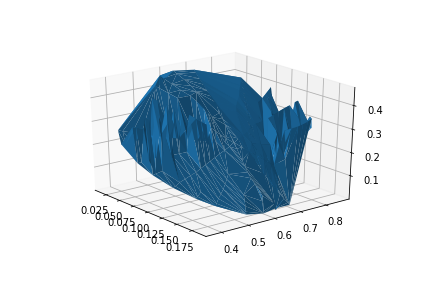

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_trisurf(ps[...,0],ps[...,1],ps[...,2],triangles=triang.simplices.copy())
plt.show()

In [57]:
triang.simplices

array([[58, 73, 72, 74],
       [58, 46, 73, 72],
       [81, 82, 66, 73],
       ...,
       [ 0,  3, 12,  2],
       [ 0,  1, 12,  8],
       [ 0,  1, 12,  2]], dtype=int32)

In [77]:
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)

In [78]:
z = np.sin(np.pi*np.meshgrid(x,y,indexing='ij')[0])*np.sin(np.pi*np.meshgrid(x,y,indexing='ij')[1])

In [79]:
grid = np.empty((x.shape[0]*y.shape[0],3))

In [80]:
grid[...,0] = np.meshgrid(x,y,indexing='ij')[0].ravel()
grid[...,1] = np.meshgrid(x,y,indexing='ij')[1].ravel()
grid[...,2] = z.ravel()

In [81]:
triangs2 = Delaunay(grid)

<IPython.core.display.Javascript object>


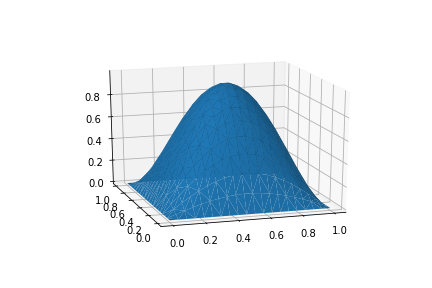

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_trisurf(grid[...,0],grid[...,1],grid[...,2],triangles=triangs2.simplices)
#ax.set_zlim(-0.1,0.1)